In [18]:
import pandas as pd
import numpy as np

# Load data into list
comp_dfs = [
    pd.read_csv("Complications_and_Deaths-Hospital2024.csv"),
    pd.read_csv("Complications_and_Deaths-Hospital2023.csv"),
    pd.read_csv("Complications_and_Deaths-Hospital2022.csv"),
    pd.read_csv("Complications and Deaths - Hospital2021.csv"),
    pd.read_csv("Complications_and_Deaths-Hospital2020.csv")
]

# Hospital list for filtering
hospital_ids = [230017, 230020, 230038, 230058, 230081, 230097, 230110, 230156,
                230222, 231320, 233300, 230059, 231322]

# Target measures for filtering
target_measures = [
    'Death rate for CABG surgery patients',
    'Death rate for COPD patients',
    'Death rate for heart attack patients',
    'Death rate for heart failure patients',
    'Death rate for pneumonia patients',
    'Death rate for stroke patients'
]

def prepare_complications_data(comp_dfs, hospital_ids, target_measures):
    keep = ['Facility ID', 'Facility Name', 'Measure ID', 'Measure Name',
            'Compared to National', 'Score', 'End Date']

    standardize_map = {
        'Better Than the National Rate': 'Better Than the National Value',
        'Better Than the National Value': 'Better Than the National Value',
        'Worse Than the National Rate': 'Worse Than the National Value',
        'Worse Than the National Value': 'Worse Than the National Value',
        'No Different Than the National Rate': 'No Different Than the National Value',
        'No Different Than the National Value': 'No Different Than the National Value',
        'Number of Cases Too Small': np.nan,
        'Not Available': np.nan
    }

    def clean(df):
        df = df.rename(columns={
            'City/Town': 'City',
            'County/Parish': 'County Name',
            'Telephone Number': 'Phone Number'
        })

        df = df[pd.to_numeric(df['Facility ID'], errors='coerce').notna()]
        df['Facility ID'] = df['Facility ID'].astype(int)
        df = df[df['Facility ID'].isin(hospital_ids)]

        for col in keep:
            if col not in df.columns:
                df[col] = pd.NA

        return df[keep]

    df = pd.concat([clean(d) for d in comp_dfs], ignore_index=True)
    df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
    df['Compared to National'] = df['Compared to National'].replace(standardize_map)
    df['Year'] = pd.to_datetime(df['End Date'], errors='coerce').dt.year
    df = df.dropna(subset=['Year'])
    df['Year'] = df['Year'].astype(int)
    df = df[df['Year'].between(2015, 2025)]
    df['Lean'] = 'YES'

    return df[df['Measure Name'].isin(target_measures)]


# Run the function
comp_death = prepare_complications_data(comp_dfs, hospital_ids, target_measures)
comp_death

,Facility ID,Facility Name,Measure ID,Measure Name,Compared to National,Score,End Date,Year,Lean
1,230017,BRONSON METHODIST HOSPITAL,MORT_30_AMI,Death rate for heart attack patients,No Different Than the National Value,13.3,06/30/2023,2023,YES
2,230017,BRONSON METHODIST HOSPITAL,MORT_30_CABG,Death rate for CABG surgery patients,No Different Than the National Value,2.8,06/30/2023,2023,YES
3,230017,BRONSON METHODIST HOSPITAL,MORT_30_COPD,Death rate for COPD patients,No Different Than the National Value,9.1,06/30/2023,2023,YES
4,230017,BRONSON METHODIST HOSPITAL,MORT_30_HF,Death rate for heart failure patients,No Different Than the National Value,14.0,06/30/2023,2023,YES
5,230017,BRONSON METHODIST HOSPITAL,MORT_30_PN,Death rate for pneumonia patients,No Different Than the National Value,19.1,06/30/2023,2023,YES
...,...,...,...,...,...,...,...,...,...
1218,233300,CHILDREN'S HOSPITAL OF MICHIGAN,MORT_30_CABG,Death rate for CABG surgery patients,NaN,NaN,12/01/2019,2019,YES
1219,233300,CHILDREN'S HOSPITAL OF MICHIGAN,MORT_30_COPD,Death rate for COPD patients,NaN,NaN,12/01/2019,2019,YES
1220,233300,CHILDREN'S HOSPITAL OF MICHIGAN,MORT_30_HF,Death rate for heart failure patients,NaN,NaN,12/01/2019,2019,YES
1221,233300,CHILDREN'S HOSPITAL OF MICHIGAN,MORT_30_PN,Death rate for pneumonia patients,NaN,NaN,12/01/2019,2019,YES


/var/folders/j5/nqhdnxcx2xs_b30brv4h83f40000gn/T/ipykernel_31678/667623525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_death_clean["Year"] = comp_death_clean["Year"].astype(int)


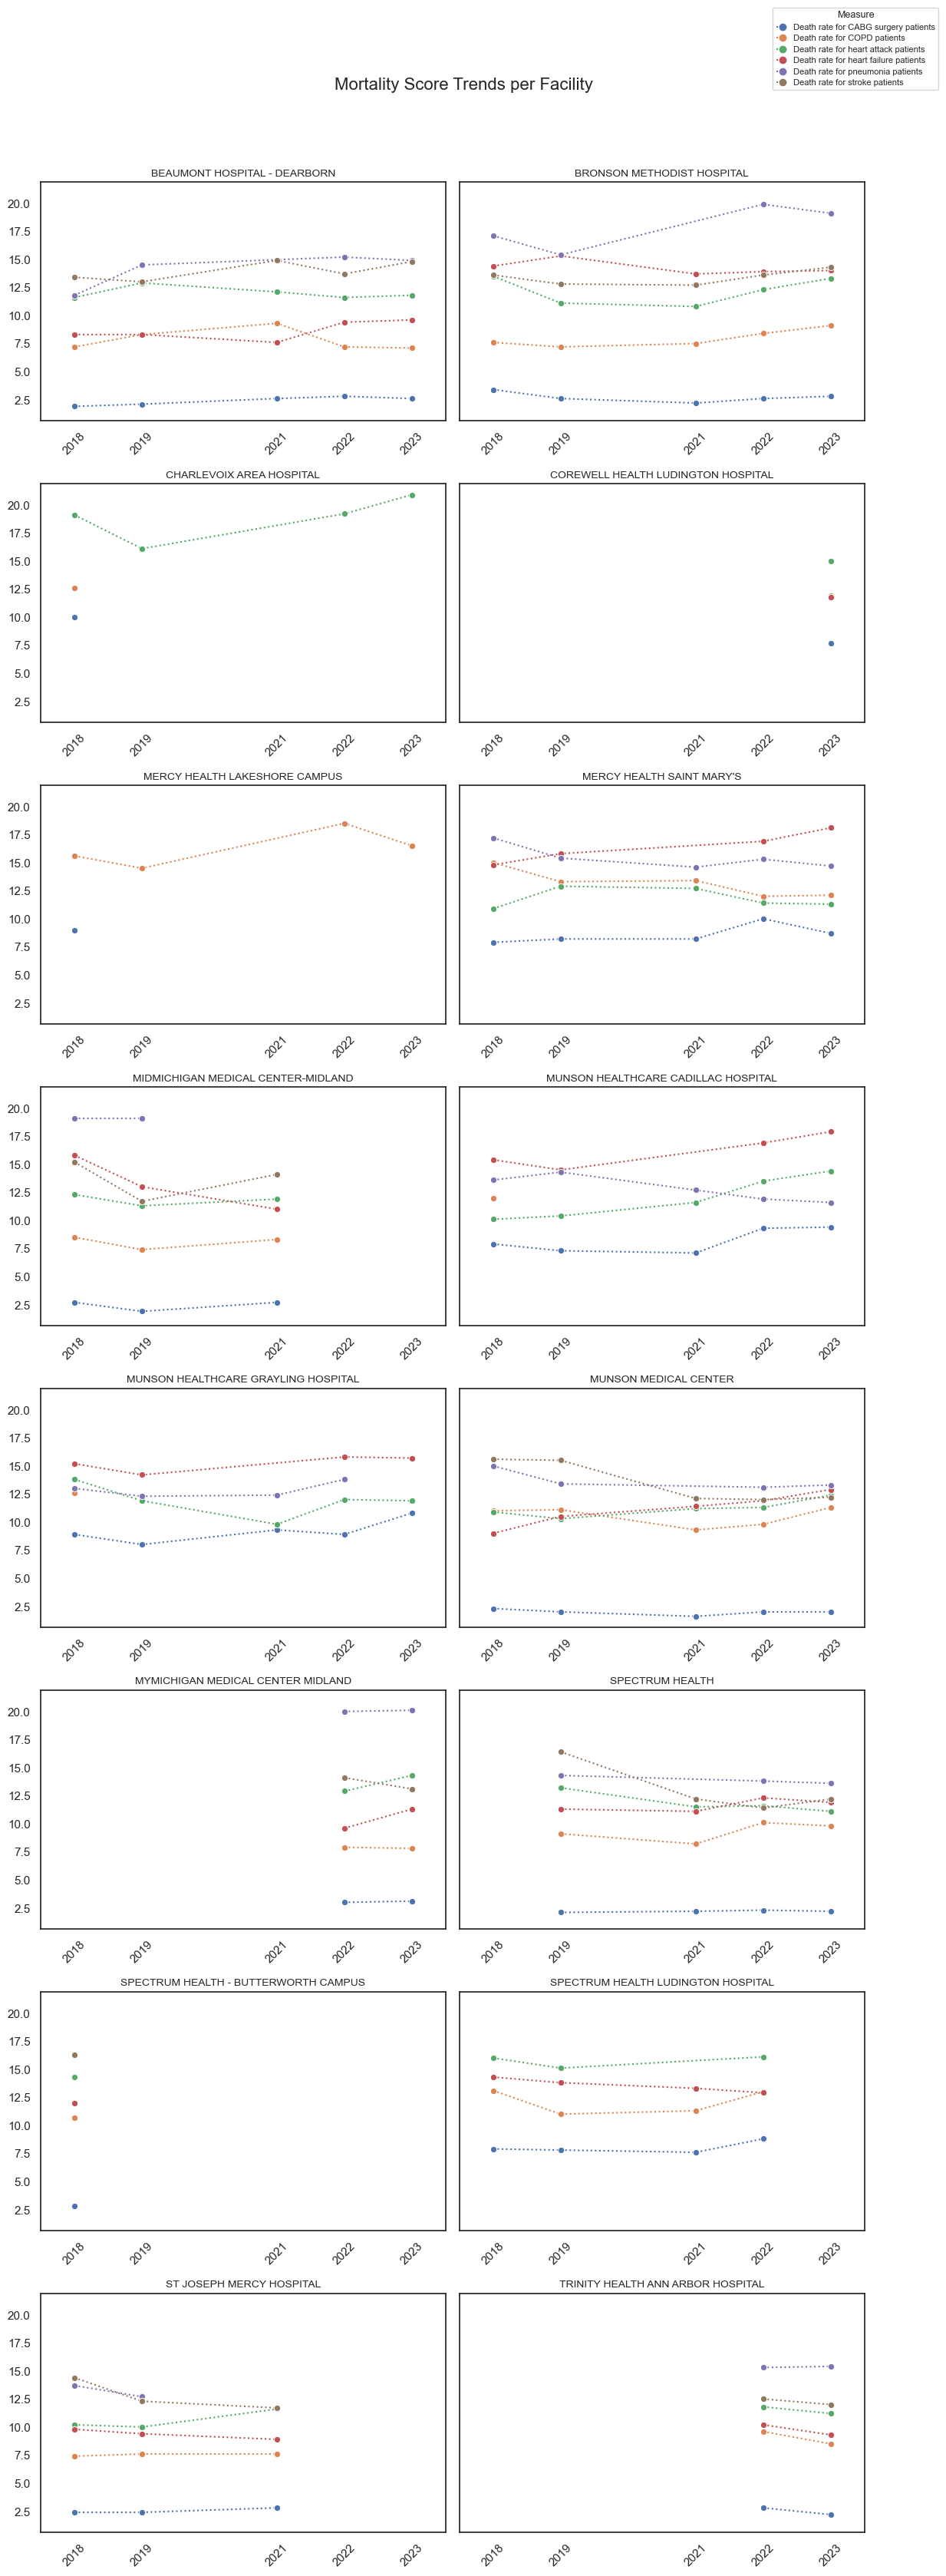

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Clean and preprocess
comp_death_clean = comp_death.dropna(subset=["Score"])
comp_death_clean["Year"] = comp_death_clean["Year"].astype(int)

# Group by Facility, Measure, Year and get average score
avg_scores = (
    comp_death_clean.groupby(["Facility Name", "Measure Name", "Year"], as_index=False)
    .agg(avg_score=("Score", "mean"))
)

# Get unique years and facilities
years = sorted(avg_scores["Year"].unique())
min_year, max_year = min(years), max(years)
facilities = avg_scores["Facility Name"].unique()
unique_measures = avg_scores["Measure Name"].unique()
n_facilities = len(facilities)

# Set up plot grid
n_cols = 2
n_rows = (n_facilities + n_cols - 1) // n_cols
sns.set(style="white")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharey=True)
axes = axes.flatten()

# Plot each facility
for i, facility in enumerate(facilities):
    ax = axes[i]
    data = avg_scores[avg_scores["Facility Name"] == facility]

    sns.lineplot(
        data=data,
        x="Year",
        y="avg_score",
        hue="Measure Name",
        marker="o",
        linestyle=":",
        ax=ax,
        legend=False  # Shared legend only
    )

    ax.set_title(facility, fontsize=10)
    ax.set_xlabel("")  # ❌ Remove x-axis label
    ax.set_ylabel("")
    ax.set_xlim(min_year - 0.5, max_year + 0.5)
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 🔧 Manually create legend handles
palette = sns.color_palette(n_colors=len(unique_measures))
legend_handles = [
    Line2D([0], [0], color=palette[i], marker='o', linestyle=':', label=measure)
    for i, measure in enumerate(unique_measures)
]

# 📍 Add shared legend in top-right
fig.legend(
    handles=legend_handles,
    title="Measure",
    title_fontsize=9,
    fontsize=8,
    loc='upper right',
    bbox_to_anchor=(1.02, 1.05),  # ⬆️ more top-right
    frameon=True,
    borderpad=0.4,
    labelspacing=0.4,
    handlelength=1.5,
    handletextpad=0.5
)

# Add overall title and adjust layout
plt.suptitle("Mortality Score Trends per Facility", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Space for legend on right
plt.savefig("mortality_trends_per_facility.png", dpi=300, bbox_inches='tight')  # Saves high-res PNG
plt.show()

